<a href="https://colab.research.google.com/github/aquangnguyen1992/global_wheat_detection/blob/master/Global_Wheat_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Mount Google Drive and create the workspace***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import shutil
shutil.copy("/content/drive/My Drive/global-wheat-detection.zip", "/content/")

'/content/global-wheat-detection.zip'

In [4]:
!sudo apt-get install unzip
!unzip "global-wheat-detection.zip" 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.
Archive:  global-wheat-detection.zip
  inflating: sample_submission.csv   
  inflating: test/2fd875eaa.jpg      
  inflating: test/348a992bb.jpg      
  inflating: test/51b3e36ab.jpg      
  inflating: test/51f1be19e.jpg      
  inflating: test/53f253011.jpg      
  inflating: test/796707dd7.jpg      
  inflating: test/aac893a91.jpg      
  inflating: test/cb8d261a3.jpg      
  inflating: test/cc3532ff6.jpg      
  inflating: test/f5a1f0358.jpg      
  inflating: train.csv               
  inflating: train/00333207f.jpg     
  inflating: train/005b0d8bb.jpg     
  inflating: train/006a994f7.jpg     
  inflating: train/00764ad5d.jpg     
  

# ***Setup the path and analysis the data***

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os
from ast import literal_eval

In [114]:
train_images_path = "/content/train/"
train_images = os.listdir(train_images_path)

test_images_path = "/content/test/"
test_images = os.listdir(test_images_path)

ground_truth = pd.read_csv("/content/train.csv")
ground_truth.head(5)
for i in range(len(ground_truth)):
  ground_truth.at[i, 'bbox'] = np.array(literal_eval(ground_truth['bbox'][i])).astype(int)

ground_truth.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834, 222, 56, 36]",usask_1
1,b6ab77fd7,1024,1024,"[226, 548, 130, 58]",usask_1
2,b6ab77fd7,1024,1024,"[377, 504, 74, 160]",usask_1
3,b6ab77fd7,1024,1024,"[834, 95, 109, 107]",usask_1
4,b6ab77fd7,1024,1024,"[26, 144, 124, 117]",usask_1


In [115]:
# Check the resolution
if len(np.unique(np.array(ground_truth['width'])))>1 or len(np.unique(np.array(ground_truth['height'])))>1:
  print("Mulitple images size for ground truth")
  
if np.any(np.array(ground_truth['bbox']) is None):
  print("No detection in some train data")
else:
  print(len(np.array(ground_truth['bbox'])), len(np.array(ground_truth['image_id'])))

# Check images format
extension = []
for each_image in train_images:
  extension.append(each_image.split(".")[-1])
if len(np.unique(np.array(extension))) > 1:
   print("Multiple extension")
   print((np.unique(np.array(extension))))
else:
   print("One image type: " + extension[0])

147793 147793
One image type: jpg


(array([ 0., 10.,  5.,  7., 12., 12.,  9.,  9., 16., 13., 15., 20., 23.,
        35., 37., 36., 34., 28., 42., 45., 55., 50., 64., 55., 33., 65.,
        63., 39., 43., 53., 64., 53., 61., 56., 69., 60., 55., 55., 67.,
        48., 46., 59., 52., 47., 56., 60., 53., 50., 48., 59., 55., 50.,
        54., 53., 56., 48., 48., 52., 50., 42., 44., 45., 42., 55., 46.,
        43., 26., 37., 35., 33., 38., 24., 26., 32., 23., 33., 21., 25.,
        21., 22., 18., 16., 25., 13., 10., 11.,  5., 10.,  5., 10.,  3.,
         0.,  5.,  2.,  2.,  4.,  3.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  

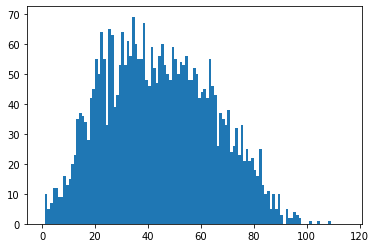

In [116]:
detection_in_image = np.unique(np.array(ground_truth['image_id']), return_index=True, return_counts=True)

#Show number of detections in each image
plt.hist(detection_in_image[2], bins=range(max(detection_in_image[2])))


In [119]:
all_indices = np.argwhere(np.array(ground_truth['image_id']) == detection_in_image[0][0])

all_bbox = []
all_indices = []
for i in range(len(detection_in_image[0])):
  if detection_in_image[2][i] > 0:
    all_indices = np.argwhere(np.array(ground_truth['image_id']) == detection_in_image[0][i])
    all_bbox.append(np.vstack(np.vstack(np.array(ground_truth['bbox']))[all_indices]))
  else:
    all_bbox.append(None)
  if i%10 == 0:
    print("Reached " + str(i))

Reached 0
Reached 10
Reached 20
Reached 30
Reached 40
Reached 50
Reached 60
Reached 70
Reached 80
Reached 90
Reached 100
Reached 110
Reached 120
Reached 130
Reached 140
Reached 150
Reached 160
Reached 170
Reached 180
Reached 190
Reached 200
Reached 210
Reached 220
Reached 230
Reached 240
Reached 250
Reached 260
Reached 270
Reached 280
Reached 290
Reached 300
Reached 310
Reached 320
Reached 330
Reached 340
Reached 350
Reached 360
Reached 370
Reached 380
Reached 390
Reached 400
Reached 410
Reached 420
Reached 430
Reached 440
Reached 450
Reached 460
Reached 470
Reached 480
Reached 490
Reached 500
Reached 510
Reached 520
Reached 530
Reached 540
Reached 550
Reached 560
Reached 570
Reached 580
Reached 590
Reached 600
Reached 610
Reached 620
Reached 630
Reached 640
Reached 650
Reached 660
Reached 670
Reached 680
Reached 690
Reached 700
Reached 710
Reached 720
Reached 730
Reached 740
Reached 750
Reached 760
Reached 770
Reached 780
Reached 790
Reached 800
Reached 810
Reached 820
Reached 830
Rea

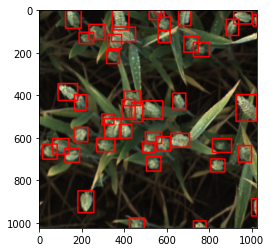

In [138]:
# Display an example
i = 1000
im = cv2.imread(os.path.join(train_images_path, detection_in_image[0][i] + "." + extension[i]))
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
boxes = all_bbox[i]
if boxes is not None:
  #print(boxes)
  for box in boxes:
    point1 = (int(box[0]), int(box[1]))
    point2 = (int(box[0]+box[2]), int(box[1]+box[3]))
    im = cv2.rectangle(im, point1, point2, (255, 0, 0), 5)
plt.imshow(im)
